<br><br>
# <b> How to Use the Python SQT Library </b> 
                                 authored by Ahmad Hasanain, revised by Muntaser Syed, supervised by Dr Veton Kepuska, and reviewed by Dr Marius Silaghi - Florida Instittue of Technology
<br>

<br>


This notebook shows how to extract the pitch track and the speech features and the reconstruct the speech signal using the extracted features. <a href="https://www.researchsquare.com/article/rs-779995/v2">Learn more about the SQT Approach</a>.



Homepage: 
<code> https://github.com/hasanainaz/sqt </code>

Installation:
<code> pip install sqtpy </code>


Initialization time: 	 2.703608274459839  (s)
/home/hasanainaz/SQT/sqt_package/sqtpy/sample_data/
1st Extraction time: 	 0.28247594833374023  (s)
2nd Extraction time: 	 0.26152920722961426  (s)
Reconstruction time: 	 0.030356407165527344  (s)


Reconstruction:


Original PCM:


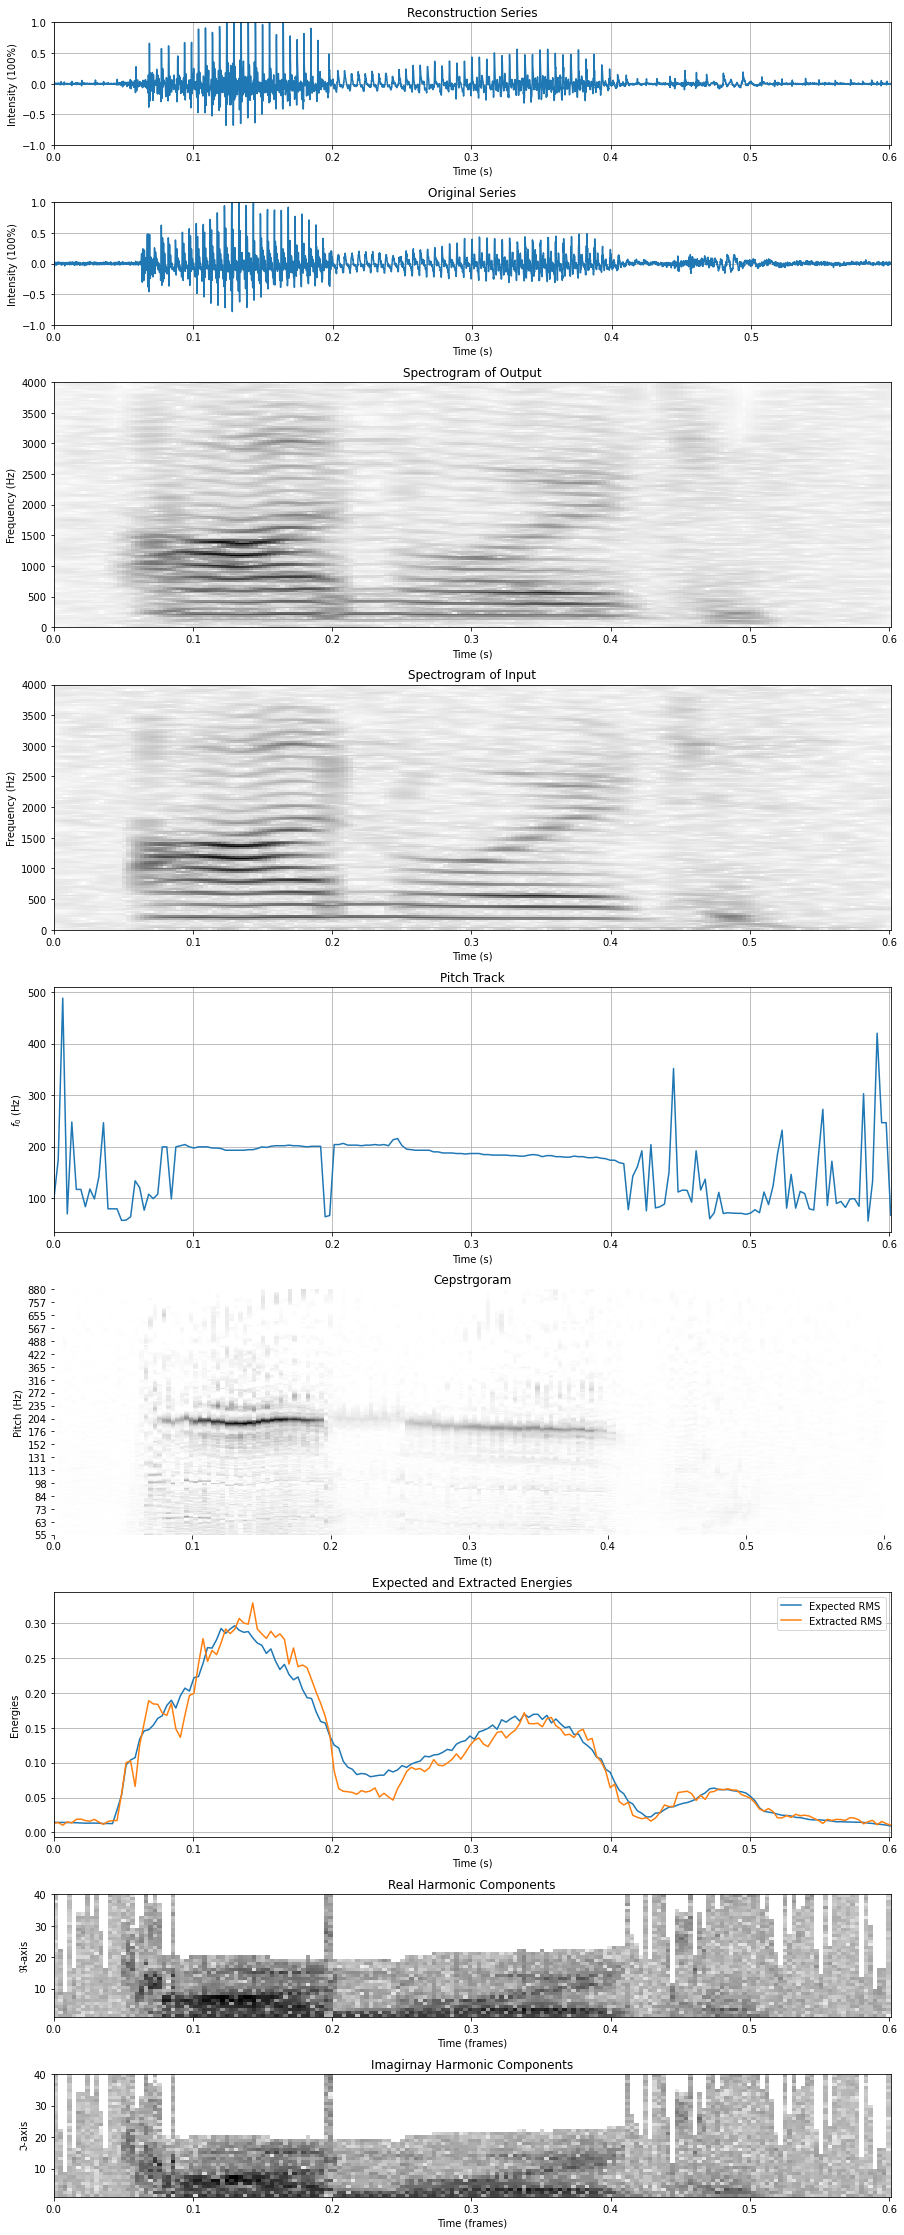



Segments


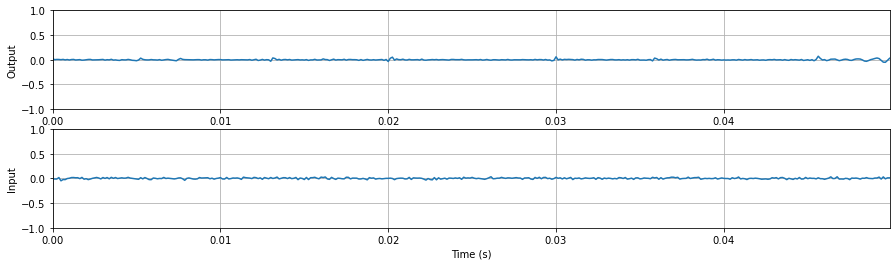

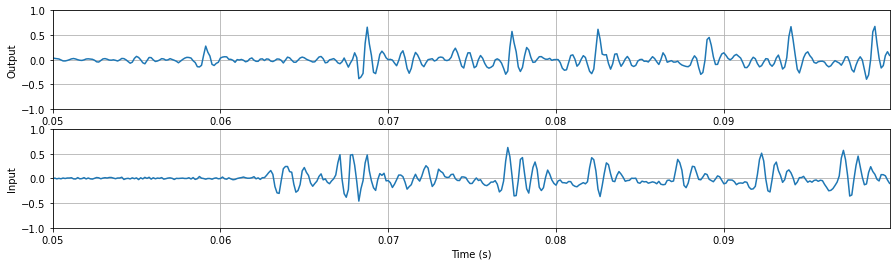

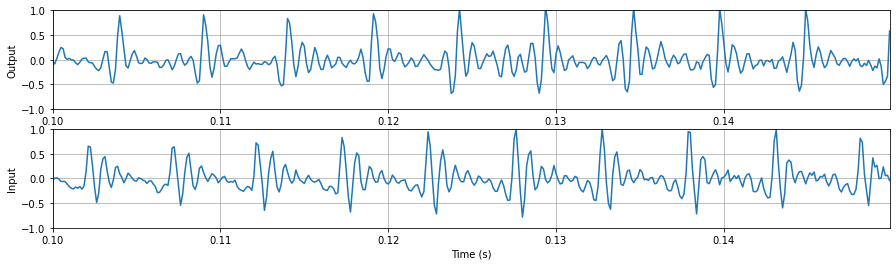

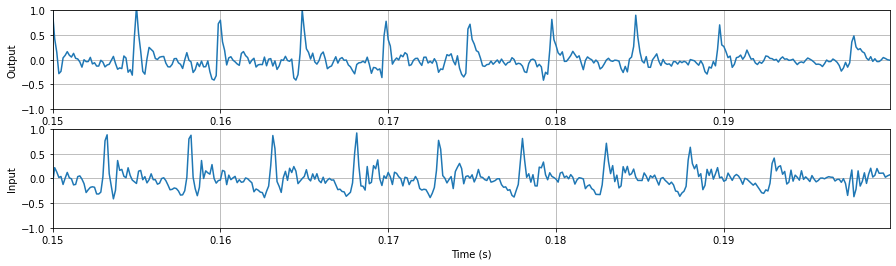

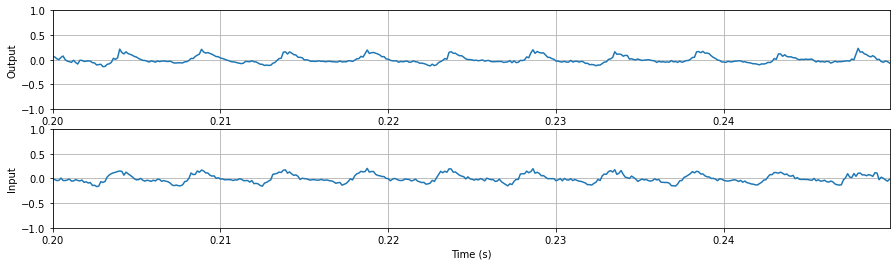

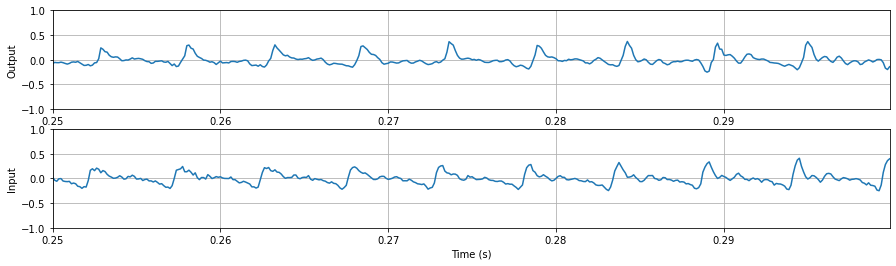

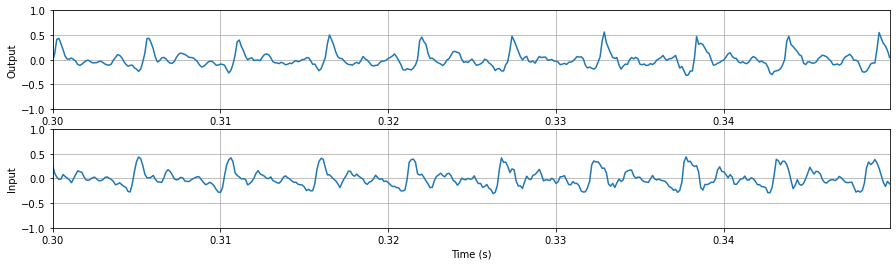

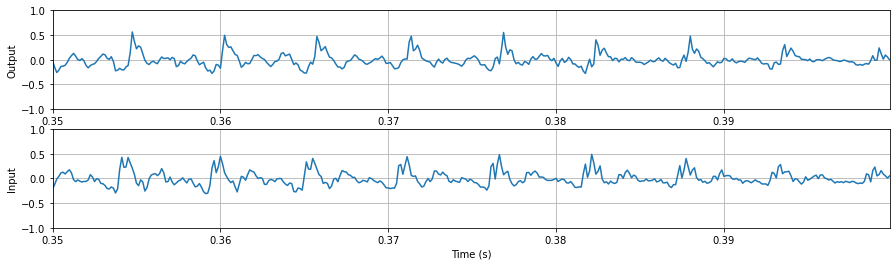

In [1]:

# libraries 
import time
import numpy as np
import scipy.io.wavfile
from IPython.display import display, Audio
import matplotlib.pyplot as plt
import sqtpy


# initalize an SQT instance
timer = time.time()
sqt = sqtpy.SQT( N = 500 , Rs = 300,  M = 40 , Fmin = 55 , Fmax = 880 , Fs = 8000,
                lifter = 1, smooth=0 )
print( "Initialization time: \t", time.time() - timer, " (s)")


# load sample signals
Fs, I1 = scipy.io.wavfile.read( sqt.data_dir + "infant.wav" , sqt.Fs )
Fs, I2 = scipy.io.wavfile.read( sqt.data_dir + "female.wav" , sqt.Fs )
Fs, I3 = scipy.io.wavfile.read( sqt.data_dir + "male.wav" , sqt.Fs )
def WhiteNoise( I , snr_db ):
    s = np.std( I ) * 10.0 ** ( - snr_db / 20.0 )
    return I + np.random.normal(loc=0.0, scale = s , size = len(I) )

# choose and mix
# I0 = I2 * 0.6 + I3 * 0.4
I0 = WhiteNoise( I2 , 20 )

# extract
timer = time.time()
[F0, Hm, Et] = sqt.encode( I0 )
print( "1st Extraction time: \t", time.time() - timer, " (s)")

# repeat extract
timer = time.time()
[F0, Hm, Et] = sqt.encode( I0 )
print( "2nd Extraction time: \t", time.time() - timer, " (s)")


# reconstruct
timer = time.time()
I = sqt.decode( F0, Hm )
print( "Reconstruction time: \t", time.time() - timer, " (s)\n\n")


# play reconscutred and origianl audio serie
print("Reconstruction:")
display( Audio( data=I  ,rate=sqt.Fs) )
print("Original PCM:")
display( Audio( data=I0 ,rate=sqt.Fs) )


# figures

fig, axes = plt.subplots(9, 1, sharex=False, figsize=(15,int(2*20)),
                         gridspec_kw={'height_ratios': [1,1,2, 2, 2,2,2,1,1]})


ax = axes[0]; ax.set_title( "Reconstruction Series" )
ax.plot( np.arange(len(I))/sqt.Fs , I )
ax.set_ylabel( 'Intensity (100%)' )
ax.set_xlabel(  'Time (s)' )
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim(bottom=-1, top=1)
ax.grid()

ax = axes[1]; ax.set_title( "Original Series" )
ax.plot( np.arange(len(I0))/sqt.Fs , I0  )
ax.set_ylabel( 'Intensity (100%)' )
ax.set_xlabel(  'Time (s)' )
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim(bottom=-1, top=1)
ax.grid()

# plot the spectrogram of reconscutred and original audios

S = sqtpy.spect( I   , sqt.c , sqt.s  ) # reconstructed signal
ax = axes[2]; ax.set_title( "Spectrogram of Output" )
im = ax.imshow(np.rot90(  S**.25  ),cmap = 'binary',aspect = 'auto',interpolation='nearest',
               extent=[0, len(S) * sqt.s / sqt.Fs, 0 , sqt.Fs/2 ] )
ax.set_ylabel(   'Frequency (Hz)'     )
ax.set_xlabel(  'Time (s)' )
S0 = sqtpy.spect( I0   , sqt.c , sqt.s ) # original signal
ax = axes[3]; ax.set_title( "Spectrogram of Input" )
im = ax.imshow(np.rot90(  S0**.25  ),cmap = 'binary',aspect = 'auto',interpolation='nearest',
               extent=[0, len(S0) * sqt.s / sqt.Fs, 0 , sqt.Fs/2 ] )
ax.set_ylabel(   'Frequency (Hz)'     )
ax.set_xlabel(  'Time (s)' )

# plot Pitch Track and Cepstrgoram

ax = axes[4]; ax.set_title( "Pitch Track" )
ax.plot( np.arange(len(F0))/sqt.Rs, F0  )
ax.set_ylabel( '$f_0$ (Hz)'  )
ax.set_xlabel(  'Time (s)' )
ax.autoscale(enable=True, axis='x', tight=True)
ax.grid()

ax = axes[5]; ax.set_title( "Cepstrgoram" )
ax.imshow(  np.rot90(sqt.Q) , cmap = 'binary'  , aspect = 'auto' , interpolation='nearest',
          extent=[0, len(sqt.Q)/sqt.Rs , 0, len(sqt.R)-1 ] )
ax.set_ylabel( 'Pitch (Hz)'  )
ax.set_xlabel(  'Time (t)' )
ax.set_frame_on(False)
hz = np.linspace(0, len(sqt.R)-1 , 20)
ax.yaxis.set_ticks( hz )
ax.yaxis.set_ticklabels( sqt.R[hz.astype(int)].astype(int).astype(str) )


# plot temporal and spectral energies

ax = axes[6]; ax.set_title( "Expected and Extracted Energies" )
ax.plot( np.arange(len(Et))/sqt.Rs, Et, label="Expected RMS" )
ax.plot( np.arange(len(Hm))/sqt.Rs, np.sqrt(np.sum(Hm[:,:sqt.M],1)**2+np.sum(Hm[:,sqt.M:],1)**2), label="Extracted RMS")
ax.set_ylabel( 'Energies' ) 
ax.set_xlabel(  'Time (s)' )
ax.autoscale(enable=True, axis='x', tight=True)
ax.grid()
ax.legend(loc='best')

ax = axes[7]; ax.set_title( "Real Harmonic Components" )
im = ax.imshow(  np.rot90(  Hm[:,:sqt.M]**0.25  ) , cmap = 'binary'  , aspect = 'auto' ,
               interpolation='nearest' , extent=[0, (len(Hm)-1)/sqt.Rs, 1, sqt.M ] )
ax.set_ylabel( '$\Re$-axis'  )
ax.set_xlabel(  'Time (frames)' )

ax = axes[8]; ax.set_title( "Imagirnay Harmonic Components" )
im = ax.imshow(  np.rot90(  Hm[:,sqt.M:]**0.25  ) , cmap = 'binary'  , aspect = 'auto' ,
               interpolation='nearest' , extent=[0, (len(Hm)-1)/sqt.Rs, 1, sqt.M  ] )
ax.set_ylabel( '$\Im$-axis'  )
ax.set_xlabel(  'Time (frames)' )

plt.subplots_adjust(hspace=0.3)
plt.show()

print("\n\nSegments")

for i in range(8):
    fig, axes = plt.subplots(2, 1, sharex=False, figsize=(15,int(2*2)) )
    
    a = int( i * 0.05 * sqt.Fs )
    b = a + int( 0.05 * sqt.Fs )
    
    ax = axes[0]
    ax.plot( np.arange(a,b)/sqt.Fs , I[a:b] )
    ax.set_ylabel( 'Output' )
    ax.set_xlabel(  'Time (s)' )
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.set_ylim(bottom=-1, top=1)
    ax.grid()

    ax = axes[1]
    ax.plot( np.arange(a,b)/sqt.Fs , I0[a:b]  )
    ax.set_ylabel( 'Input' )
    ax.set_xlabel(  'Time (s)' )
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.set_ylim(bottom=-1, top=1)
    ax.grid()

    
    

<br><br><br>

### <b>Acknowledgements:</b>
* Ahmad Hasanain, Muntaser Syed, Veton Kepuska, Marius Cilaghi, "Speech Quefrency Transform" - 2022, ResearchSqaure.
* Veton Z Kepuska, "Wake-up-word speech recognition application for first responder communication enhancement" - 2006, Florida Institute of Technology (WUW-I Speech Corpus).
* Minnesota Department of Health, "4 - Baby Behavior: Crying baby" - 2017, Youtube. 
